In [1]:
import numpy as np
import tensorflow as tf
import graph_nets as gn
import sonnet as snt
import matplotlib.pyplot as plt
import math
import gc

import read_orbits
from solar_system_names import *
from ml_model import *

Global Constants

In [2]:
# Global constants
AU = 149.6e6 * 1000 # Astronomical Unit in meters.
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (0.5/24.) # 2 hours
MSUN = 1.9885e+30
MEARTH = 5.9724e+24
G = 6.67428e-11/AU**3*MEARTH*DAY**2

Training variables

In [3]:
# Training variables
patience = 5
d_patience = 0
noise_level = 0.05
log_every_iterations = 1000
num_training_iterations = 200000

# Do not change this
#total_time_traj = 40 #Years
#num_time_steps_total = int(total_time_traj/delta_time)
num_time_steps_tr = 520000 #An orbit for saturn is 129110 steps
num_time_steps_sr = 500
num_batches = 1300
#num_time_steps_val = int(total_time_traj/delta_time) - num_time_steps_tr

Read the data

In [4]:
def force_newton(x, m1, m2):
    return G*m1*m2/np.linalg.norm(x, axis = -1, keepdims=True)**3.*x

In [5]:
nplanets = 8 # Number of planets (not counting the sun)
data, masses, names = read_orbits.main(nplanets = nplanets, frame='b', use_moons = True, 
                                       path='/Users/Pablo/Dropbox/data/orbits/7parts/full/')
nplanets = len(data[0])
nedges = nplanets*(nplanets-1)//2
batch_size_tr = num_time_steps_tr//num_batches

# Get the acceleration
A = data[1:,:,3:] - data[:-1,:,3:]
data[:-1, :, 3:] = A/delta_time 
data = data[:-1]

# For debugging, reduce size of validation data. Really speeds things up!
nval = 10000
data = data[:(num_time_steps_tr + nval)]

masses/=MSUN#/1000000

# Split into training and validation
data_tr = data[:num_time_steps_tr]
data_val = data[num_time_steps_tr:]

num_time_steps_val = len(data_val)

# Shuffle the data
np.random.shuffle(data_tr)
np.random.shuffle(data_val)

num_time_steps_tr = 130000
data_tr = data_tr[:num_time_steps_tr]

Reading data in Solar System barycenter reference frame
Reading data for mercury
Reading data for venus
Reading data for earth
Reading data for moon
Reading data for mars
Reading data for jupiter
Reading data for io
Reading data for europa
Reading data for ganymede
Reading data for callisto
Reading data for saturn
Reading data for mimas
Reading data for enceladus
Reading data for tethys
Reading data for dione
Reading data for rhea
Reading data for titan
Reading data for hyperion
Reading data for iapetus
Reading data for phoebe
Reading data for uranus
Reading data for ariel
Reading data for umbriel
Reading data for titania
Reading data for oberon
Reading data for miranda
Reading data for neptune
Reading data for triton
Reading data for nereid
Reading data for proteus
Finished reading data
The data array contains 31 bodies.


In [6]:
D_tr_np = np.empty([len(data_tr), nedges, 3])
D_val_np = np.empty([len(data_val), nedges, 3])
data_norm = np.empty([len(data_tr), nedges, 3])
F_val = np.empty([len(data_val), nedges, 3])
k=0
names_edges = []
senders, receivers = [], []
for i in range(nplanets):
    for j in range(nplanets):
        if i > j:
            d_tr = data_tr[:,j,:3] - data_tr[:,i,:3]
            d_val = data_val[:,j,:3] - data_val[:,i,:3]
            D_tr_np[:,k,:] = d_tr#cartesian_to_spherical_coordinates(d_tr)
            D_val_np[:,k,:] = d_val #cartesian_to_spherical_coordinates(d_val)
            F_val[:,k,:] = force_newton(d_val, masses[i], masses[j]) #cartesian_to_spherical_coordinates(d_val)
            names_edges.append(names[j] + ' - ' + names[i])
            #data_norm[:,k,0] = np.log10(masses[i])
            #data_norm[:,k,1] = np.log10(masses[j])
            #data_norm[:,k,2] = np.log10(G)
            k+=1 
            receivers.append(i)
            senders.append(j)

A_tr = data_tr[:,:,3:]
A_val = data_val[:,:,3:]
A_norm =np.std(A_tr) 
#A_norm = 1.

D_tr_flat = np.reshape(D_tr_np, [num_time_steps_tr*nedges, 3])
D_val_flat = np.reshape(D_val_np,[1, num_time_steps_val*nedges, 3])

#A_tr_sph = cartesian_to_spherical_coordinates(A_tr/A_norm)
#A_val_sph = cartesian_to_spherical_coordinates(A_val/A_norm)
A_tr_flat = np.reshape(A_tr/A_norm, [num_time_steps_tr*nplanets, 3])
A_val_flat = np.reshape(A_val/A_norm, [1, num_time_steps_val*nplanets, 3])

D_tr = tf.convert_to_tensor(D_tr_flat, dtype="float32")
A_tr = tf.convert_to_tensor(A_tr_flat, dtype="float32")

#maxA = tf.reduce_max(A_tr_sph, axis = 0)
#minA = tf.reduce_min(A_tr_sph, axis = 0)
#A_tr_sph_norm = 2*(A_tr_sph - minA)/(maxA-minA)-1
#A_val_sph_norm = 2*(A_val_sph - minA)/(maxA-minA)-1

D_tr_batches = tf.split(D_tr,  num_batches)
A_tr_batches = tf.split(A_tr,  num_batches)

D_val = tf.convert_to_tensor(D_val_flat, dtype="float32")
A_val = tf.convert_to_tensor(A_val_flat, dtype="float32")

train_ds = tf.data.Dataset.from_tensor_slices(
    (D_tr_batches, A_tr_batches))

test_ds = tf.data.Dataset.from_tensor_slices(
    (D_val, A_val))

In [7]:
A_tr = None
A_val = None
D_tr = None
#D_val = None
A_tr_flat = None
A_val_flat = None
D_tr_flat = None
#D_val_flat = None
A_tr_batches = None
D_tr_batches = None
data = None
data_tr = None
gc.collect()

20

In [8]:
checkpoint_filepath = './saved_models/saved2'

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                            verbose = 1,
                                            patience=20,
                                            #baseline = 0.1,
                                            restore_best_weights=False)
# Restore best weights not working, but found way around using checkpoint

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_weights_only=False,
                                                save_best_only=True,
                                                 verbose=0)
model = LearnForces(nplanets, senders, receivers, noise_level = noise_level)

#model.compile(run_eagerly=True)
model.compile()

In [ ]:
# The goal is a validation loss 0.0149

model.fit(train_ds, 
          epochs = 1000, 
          verbose=2,
          #callbacks=[early_stopping], 
          callbacks=[early_stopping, checkpoint], 
          validation_data=test_ds
         )


Epoch 1/1000
g nodes before = Tensor("learn_forces/strided_slice:0", shape=(30, 1), dtype=float32)
g edges before = Tensor("learn_forces/data_dicts_to_graphs_tuple/concat_1/concat:0", shape=(46500, 3), dtype=float32)
g nodes = Tensor("learn_forces/strided_slice_1:0", shape=(30, 1), dtype=float32)
g edges= Tensor("edge_block/linear/Add:0", shape=(46500, 3), dtype=float32)
f = Tensor("learn_forces/sub:0", shape=(3100, 3), dtype=float32)
a = Tensor("learn_forces/truediv_2:0", shape=(3100, 3), dtype=float32)
g nodes before = Tensor("learn_forces/strided_slice:0", shape=(30, 1), dtype=float32)
g edges before = Tensor("learn_forces/data_dicts_to_graphs_tuple/concat_1/concat:0", shape=(46500, 3), dtype=float32)
g nodes = Tensor("learn_forces/strided_slice_1:0", shape=(30, 1), dtype=float32)
g edges= Tensor("edge_block/linear/Add:0", shape=(46500, 3), dtype=float32)
f = Tensor("learn_forces/sub:0", shape=(3100, 3), dtype=float32)
a = Tensor("learn_forces/truediv_2:0", shape=(3100, 3), dtype=fl

In [13]:
loss_tracker

In [22]:
model.load_weights(checkpoint_filepath)

model.evaluate(test_ds)

1/1 [==============================] - 6s 6s/step - loss: 0.2322


0.23224906623363495

In [28]:
np.round(model.logm_planets.numpy(), 1)

array([13.5, -0.2, 14.2,  1.9,  0.9,  3.4,  7.3, -0.5, -0.1,  0.3,  0.8,
        5.6, -0.5, -0.3, -0.1,  0.1,  0.4,  1.1,  1.3,  1.4,  1.2,  7.3,
        0.3,  0.8,  1.6,  2.7, -0. ,  5.6,  1.9,  2.6, -0.1],
      dtype=float32)

In [30]:
np.round(model.logm_planets.numpy() - 10, 2)

array([  3.51, -10.15,   4.21,  -8.06,  -9.08,  -6.61,  -2.73, -10.47,
       -10.11,  -9.67,  -9.18,  -4.43, -10.49, -10.28, -10.06,  -9.87,
        -9.63,  -8.85,  -8.7 ,  -8.63,  -8.77,  -2.74,  -9.66,  -9.23,
        -8.41,  -7.28, -10.01,  -4.45,  -8.06,  -7.39, -10.15],
      dtype=float32)

In [19]:
np.round(np.log10(masses), 2)

array([  0.  ,  -6.78,  -5.61,  -5.52,  -7.43,  -6.49,  -3.02,  -7.35,
        -7.62,  -7.13,  -7.27,  -3.54, -10.72, -10.27,  -9.51,  -9.26,
        -8.94,  -7.17, -11.55,  -9.04, -11.38,  -4.36,  -9.2 ,  -9.19,
        -8.77,  -8.81, -10.49,  -4.29,  -7.97, -10.81, -10.66])

# Evaluate on validation data

In [ ]:
ap ,fp = model(D_val_flat[0], extract = True)


In [ ]:
nrows = math.ceil(nplanets/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nplanets):
    ax[i//4, i%4].set_title(names[i], fontsize = 16)
    ax[i//4, i%4].plot(ap[:,i,0], ap[:,i,1], '.', label = 'Learned')
    ax[i//4, i%4].plot(data_val[:,i,3]/A_norm, data_val[:,i,4]/A_norm, '.', label = 'Truth')

ax[0,0].legend()
#plt.savefig('/Users/Pablo/Desktop/full_learnedmasses.png')

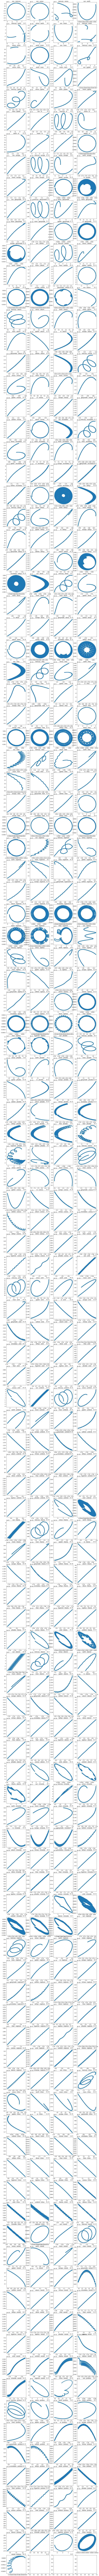

In [116]:
nrows = math.ceil(nedges/4)
fig, ax = plt.subplots(nrows, 4, figsize = (16, 4*nrows))
for i in range(nedges):
    ax[i//4, i%4].set_title(names_edges[i])
    #ax[i//4, i%4].plot(F_val[:,i,0], F_val[:,i,1], '.')
    ax[i//4, i%4].plot(fp[:,i,0]*A_norm, fp[:,i,1]*A_norm, '.')
#plt.savefig('/Users/Pablo/Desktop/forces_learnedmasses.png')

In [30]:
model.logG.numpy()

array([-1.4395287], dtype=float32)

In [32]:
np.log10(G/A_norm)

-6.880635818430139

In [173]:
dv = tf.reshape(D_val, [-1, nedges, 3])
dv, fp = rotate_data(dv, fp)
F_pred_sr = np.empty([num_time_steps_sr, nedges, 3])
D_val_sr = np.empty([num_time_steps_sr, nedges, 3])
for i in range(num_time_steps_sr):
    Dv_temp, Fp_temp = rotate_data(dv[i], fp[i])
    F_pred_sr[i] = Fp_temp
    D_val_sr[i] = Dv_temp


In [174]:
'''
indices = [0,1,3,6,10,15,21]
X = np.zeros([(nplanets-1)*num_time_steps_sr,5])
F = np.zeros([(nplanets-1)*num_time_steps_sr,3])
F_norm = np.mean(F_pred_sr)
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if ((i>j) and (j==0)):
            print(i,j,k, indices[i])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = masses[i]
           #X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = masses[j]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1:4] = D_val_sr[:,indices[k],:]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,4] = np.linalg.norm(D_val_sr[:,indices[k],:], axis = -1)#**3
            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = F_pred_sr[:,indices[k],:]#/F_norm #works better with
            k+=1
'''

'\nindices = [0,1,3,6,10,15,21]\nX = np.zeros([(nplanets-1)*num_time_steps_sr,5])\nF = np.zeros([(nplanets-1)*num_time_steps_sr,3])\nF_norm = np.mean(F_pred_sr)\nk=0\nfor i in range(nplanets):\n    for j in range(nplanets):\n        if ((i>j) and (j==0)):\n            print(i,j,k, indices[i])\n            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = masses[i]\n           #X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = masses[j]\n            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1:4] = D_val_sr[:,indices[k],:]\n            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,4] = np.linalg.norm(D_val_sr[:,indices[k],:], axis = -1)#**3\n            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = F_pred_sr[:,indices[k],:]#/F_norm #works better with\n            k+=1\n'

In [28]:
np.round(np.log10(masses)[1:], 2)

array([-1.26, -0.09,  0.  , -1.91, -0.97,  2.5 , -1.83, -2.09, -1.61,
       -1.74,  1.98, -3.99, -3.74, -3.41, -1.64])

In [213]:
X = np.zeros([nedges*num_time_steps_sr,6])
F = np.zeros([nedges*num_time_steps_sr,3])
weights = np.zeros(nedges*num_time_steps_sr)
k=0
masses_learned = np.zeros(nplanets)
masses_learned[0] = masses[0]
masses_learned[1:] = 10**model.logm_planets.numpy()
for i in range(nplanets):
    for j in range(nplanets):
        if i>j:
            #X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = masses[i]
            #X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = masses[j]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = np.log(masses_learned[i])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = np.log(masses_learned[j])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,2:5] = D_val_sr[:,k,:]
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,5] = np.linalg.norm(D_val_sr[:,k,:], axis = -1)#**3
            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = F_pred_sr[:,k,:]#/F_norm #works better with
            invw = np.mean(np.linalg.norm(F_pred_sr[:,k,:], axis = -1))
            if invw <1e-50:
                weights[k*num_time_steps_sr:(k+1)*num_time_steps_sr] = 1e-100
            else: 
                weights[k*num_time_steps_sr:(k+1)*num_time_steps_sr] = -np.log10(invw)
            k+=1


In [218]:
weights/=max(weights)

In [219]:
from pysr import pysr
# Learn equations
equations = []
for i in range(1):
    equation = pysr(X[:,:], F[:,i], niterations=10,
                    #batching = True, 
                    #batchSize = 500,
            weights = weights,      
            #maxsize = 100,
            populations = 4,
            variable_names = ['m0', 'm1', 'x', 'y', 'z', 'r'],
            binary_operators=["mult", "div"],
            unary_operators=["square", "cube"],            
            #binary_operators=["plus", "sub", "mult", "div"],
            #unary_operators=["square", "cube", "exp", "logm", "logm10"],
                   )
    equations.append(equation)

Running on julia -O3 -p 4 /var/folders/g2/89155hgd7fq1_lb47r__q4240000gn/T/tmpmvxwrpgv/runfile.jl
Started!

Cycles per second: 2.400e+04
Hall of Fame:
-----------------------------------------
Complexity  MSE        Score     Equation
0           -2.093e-04  0.000e+00  0.000014

Killing process... will return when done.


In [220]:
max(weights)

1.0

In [49]:
F.shape

(513000, 3)

In [ ]:
F

In [144]:
def asCartesian(rthetaphi):
    #takes list rthetaphi (single coord)
    r,theta,phi = np.split(rthetaphi, )
    r       = rthetaphi[0]
    theta   = rthetaphi[1]* pi/180 # to radian
    phi     = rthetaphi[2]* pi/180
    x = r * sin( theta ) * cos( phi )
    y = r * sin( theta ) * sin( phi )
    z = r * cos( theta )
    return [x,y,z]

def asSpherical(xyz):
    #takes list xyz (single coord)
    x, y, z = np.split(xyz, 3, axis=-1)
    r       =  np.sqrt(x*x + y*y + z*z)
    theta   =  np.arccos(z/r)#*180/ pi #to degrees
    phi     =  np.arctan2(y,x)#*180/ pi
    return np.concatenate([np.log10(r+1e-20),theta,phi], axis = -1)

In [145]:
a = np.zeros([500,1])
np.concatenate([a,a], axis = -1).shape

(500, 2)

In [153]:
X = np.zeros([nedges*num_time_steps_sr,6])
F = np.zeros([nedges*num_time_steps_sr,3])
F_norm = np.mean(F_pred_sr)
k=0
for i in range(nplanets):
    for j in range(nplanets):
        if ((i>j) and (min(np.linalg.norm(F_pred_sr[:,k,:], axis = -1))>0)):
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,0] = np.log10(masses[i])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,1] = np.log10(masses[j])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,2:5] = asSpherical(D_val_sr[:,k,:])
            X[k*num_time_steps_sr:(k+1)*num_time_steps_sr,5] = np.log10(np.linalg.norm(D_val_sr[:,k,:], axis = -1))#**3
            F[k*num_time_steps_sr:(k+1)*num_time_steps_sr,:] = asSpherical(F_pred_sr[:,k,:])#/F_norm #works better with
            k+=1



In [156]:
np.sum(np.isnan(F))

0

In [160]:
from pysr import pysr
# Learn equations
equations = []
for i in range(1):
    equation = pysr(X[:,:], F[:,i]/np.std(F[:,i]), niterations=20,
            #maxsize = 100,
            populations = 16,
            variable_names = ['m0', 'm1', 'x', 'y', 'z', 'r'],
            binary_operators=["plus", "sub", "mult", "div"],
            unary_operators=[])
    equations.append(equation)

Running on julia -O3 -p 4 /var/folders/g2/89155hgd7fq1_lb47r__q4240000gn/T/tmpr9_rr2j0/runfile.jl


In [162]:
equations[0]

,Complexity,MSE,score,Equation,sympy_format,lambda_format
0,1,1.000000,0.000000e+00,0.007120792,0.00712079200000000,<function _lambdifygenerated at 0x7fe559301a70>
1,2,1.000000,-0.000000e+00,cube(0.19122349),0.00699235904731083,<function _lambdifygenerated at 0x7fe559301050>
2,3,0.999825,1.748753e-04,"div(8.210703e-5, r)",8.210703e-5/r,<function _lambdifygenerated at 0x7fe559301560>
3,7,0.998487,3.348577e-04,"div(0.00036552057, div(r, div(x, r)))",0.00036552057*x/r**2,<function _lambdifygenerated at 0x7fe559301f80>
4,9,0.998486,9.013642e-08,"div(0.00066697237, div(mult(r, 1.8231077), div...",0.000365843647086785*x/r**2,<function _lambdifygenerated at 0x7fe558cbb3b0>


# TO DO:

### To finish the project
- Nearly working
- Try without spherical?

### To clean the model
- Separate modules
- Include some kind of training progress bar
- Improve plotting
- Add to Colab

### Problems to fix
- I think the reason it is not learning the orbits of io, and mimas-dione is their tiny orbital period (less than a day in some cases!). I need either lots more data, or maybe to include the errors in the data

# Requirements
- The graphnets tensorflow 2 installation
- pysr